In [1]:
import numpy as np
 
class MarkovChain(object):
    def __init__(self, transition_prob):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_prob: dict
            A dict object representing the transition 
            probabilities in Markov Chain. 
            Should be of the form: 
                {'state1': {'state1': 0.1, 'state2': 0.4}, 
                 'state2': {...}}
        """
        self.transition_prob = transition_prob
        self.states = list(transition_prob.keys())
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        next_states = list(self.transition_prob[current_state].keys())
        return np.random.choice(
            next_states, 
            p=[self.transition_prob[current_state][next_state] 
               for next_state in next_states]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states
    
    def get_transition_probability_for_sequence(self, current_state, following_states):
        """
        Calculate the transition probability of a sequence of tokens. 
        Multiply the current probability by the probability of the next transition (current to next state).
        The method is called recursively with the first token in the following_states is 
            deemed to be the next 'current_state'.
        
        Parameters
        ----------
        current_state: str
            The current state (token).
 
        following_states: list
            The list of the tokens next in sequence.
            
        prob: float
            The probability of the sequence until current_state.
        """
        if len(following_states) <= 1:
            return 1
        
        if current_state not in self.transition_prob:
            self.transition_prob[current_state] = {}
        
        next_state = following_states[0]
        
        if next_state not in self.transition_prob[current_state]:
            self.transition_prob[current_state][next_state] = 1
            
        prob = self.transition_prob[current_state][next_state] * self.get_transition_probability_for_sequence(next_state, following_states[1:])
        return prob

In [2]:
import pandas as pd

import nltk
import string

from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer

porter = PorterStemmer()

wordnet_lemmatizer = WordNetLemmatizer()


df = pd.read_csv("spam.csv", encoding='latin-1')

data = df[['v1', 'v2']]

In [3]:
"""
Split the dataset into train and test set.
"""
data_copy = data.copy()
train_set = data_copy.sample(frac=0.75, random_state=0)
test_set = data_copy.drop(train_set.index)

In [4]:
""" 
Iterate through each message, tokenize and normalize it. Each processed token is then added to the 
word_dict which is a nested dictionary holding all the tokens that follow the given token along with 
their count corresponding to this token.

E.g.,
{
    "token_1": {"token_2": 10, "token_3": 5}
}

This data will be used to calculate the probability of each following token given the primary token.
The calculated probability is the transition probability from token_1 to token_2 and token_3.
"""
def get_word_dictionary(data, class_tag):
    word_dict = {}

    for index, row in data.iterrows():
        """
        Fetch the class and the message into two separate variables.
        """
        tag = row['v1']
        if tag != class_tag:
            continue
        
        message = row['v2']

        """
        Tokenize the message text and normalize it by removing the punctuations.
        """
        msg_tokens = word_tokenize(message)
        last_token = None
        for token in msg_tokens:
            normalized_token = token.lower()

            if normalized_token in string.punctuation:
                continue

            """
            Lemmatize the word before adding it to the markov chain.
            """
            lemmatized_token = wordnet_lemmatizer.lemmatize(normalized_token)

            if last_token is not None:
                if last_token in word_dict:
                    sub_dict = word_dict[last_token] 
                else:
                    sub_dict = {}
                    word_dict[last_token] = sub_dict

                if not lemmatized_token in sub_dict:
                    sub_dict[lemmatized_token] = 1 
                else:
                    sub_dict[lemmatized_token] += 1
            else:
                word_dict[lemmatized_token] = {}

            last_token = lemmatized_token

    return word_dict

In [5]:
""" 
Iterate through each message, normalize and create the char_dict in an way similar to get_word_dictionary(). In this case
spaces need to be considered characters too. Lemmatization is ommitted because it may remove the very information that is 
unique to the character-sequences compared to word-sequences.
E.g.,
{
    "char_1": {"char_2": 10, "char_3": 9, "char_4": 5}
}

"""
def get_char_dictionary(data, class_tag):
    char_dict = {}
    
    for index, row in data.iterrows():
        """
        Fetch the class and the message into two separate variables.
        """
        tag = row['v1']
        if tag != class_tag:
            continue
        
        message = row['v2']

        """
        Normalize the message by turning it lowercase
        """
        normalized_message = message.lower()
        last_char = None
        
        for char in normalized_message:
            """
            If char is part of punctuation don't consider it
            """
            if char in string.punctuation:
                continue
                
            """
            Generate nested dictionaries and add them to the main one
            """
            if last_char is not None:
                if last_char in char_dict:
                    sub_dict = char_dict[last_char]
                else:
                    sub_dict = {}
                    char_dict[last_char] = sub_dict
                
                if not char in sub_dict:
                    sub_dict[char] = 1
                else:
                    sub_dict[char] += 1
            else:
                char_dict[char] = {}
                
            last_char = char
            
    return char_dict
 

In [6]:
"""
Prepare the word dictionary for the training set of each class type.
"""
ham_word_dict_train = get_word_dictionary(train_set, 'ham')
spam_word_dict_train = get_word_dictionary(train_set, 'spam')

"""
Prepare the word dictionary for the test set of each class type.
"""
ham_word_dict_test = get_word_dictionary(test_set, 'ham')
spam_word_dict_test = get_word_dictionary(test_set, 'spam')

"""
Prepare the char dictionary for the training set of each class type.
"""
ham_char_dict_train = get_char_dictionary(train_set, 'ham')
spam_char_dict_train = get_char_dictionary(train_set, 'spam')

"""
Prepare the char dictionary for the test set of each class type.
"""
ham_char_dict_test = get_char_dictionary(test_set, 'ham')
spam_char_dict_test = get_char_dictionary(test_set, 'spam')

In [7]:
"""
Calculates and returns the transition probabilities for the provided word dictionary. 
"""
def get_transition_probabilities(dictionary):
    prob_dictionary = {}
    
    for key in dictionary:
        sub_dictionary = dictionary[key]
        count = 0
        for transition in sub_dictionary:
            count+=sub_dictionary[transition]
        
        prob_sub_dictionary = {}
        for transition in sub_dictionary:
            prob_sub_dictionary[transition] = sub_dictionary[transition]/count
        
        prob_dictionary[key] = prob_sub_dictionary
        
    return prob_dictionary

In [8]:
"""
Get the transition probabilities for the training set of all class types for the word chain.
"""
ham_word_transition_prob_train = get_transition_probabilities(ham_word_dict_train)
spam_word_transition_prob_train = get_transition_probabilities(spam_word_dict_train)

"""
Get the transition probabilities for the test set of all class types for the word chain.
"""
ham_word_transition_prob_test = get_transition_probabilities(ham_word_dict_test)
spam_word_transition_prob_test = get_transition_probabilities(spam_word_dict_test)

"""
Get the transition probabilities for the training set of all class types for the character chain.
"""
ham_char_transition_prob_train = get_transition_probabilities(ham_char_dict_train)
spam_char_transition_prob_train = get_transition_probabilities(spam_char_dict_train)

"""
Get the transition probabilities for the test set of all class types for the character chain.
"""
ham_char_transition_prob_test = get_transition_probabilities(ham_char_dict_test)
spam_char_transition_prob_test = get_transition_probabilities(spam_char_dict_test)

In [9]:
"""
Instantiate four different Markov chain graphs for the Ham and Spam message types for both word and character chains.
"""
ham_word_chain = MarkovChain(transition_prob=ham_word_transition_prob_train)
spam_word_chain = MarkovChain(transition_prob=spam_word_transition_prob_train)

ham_char_chain = MarkovChain(transition_prob=ham_char_transition_prob_train)
spam_char_chain = MarkovChain(transition_prob=spam_char_transition_prob_train)

# ham_chain.generate_states(current_state='u', no=50) 

In [10]:
# ham_prob = ham_chain.get_transition_probability_for_sequence()
# spam_prob = spam_chain.get_transition_probability_for_sequence()

In [11]:
def get_test_message_token_sequence(message, token_type):
    token_sequence = []
    
    """
    Normalize the message by turning it to lowercase and ignoring punctuations.
    """
    if token_type == 'word':
        msg_tokens = word_tokenize(message)
    else:
        msg_tokens = message.lower()

    for token in msg_tokens:
        normalized_token = token.lower()

        if normalized_token in string.punctuation:
            continue
        token_sequence.append(normalized_token)
        
    return token_sequence

def process_test_messages(data, token_type):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for index, row in data.iterrows():
        """
        Fetch the class and the message into two separate variables.
        """
        tag = row['v1']
        
        message = row['v2']
        if token_type == 'word':
            model_tag = process_word_test_message_get_tag(message)
        else:
            model_tag = process_char_test_message_get_tag(message)
            
        if model_tag == 'spam' and tag == 'spam':
            TN+=1
        if model_tag == 'ham' and tag == 'spam':
            FP+=1
        if model_tag == 'spam' and tag == 'ham':
            FN+=1
        if model_tag == 'ham' and tag == 'ham':
            TP+=1
        
    return (TP, FP, TN, FN)

    
"""
Processes a raw message, converts it to sequence of tokens and calculates its Ham and Spam probabilities. 
The method returns 'ham' if the message is identified as Spam, and 'spam' if it is a Ham.
"""
def process_word_test_message_get_tag(message):
    token_sequence = get_test_message_token_sequence(message, 'word')
    ham_prob = ham_word_chain.get_transition_probability_for_sequence(token_sequence[0], token_sequence[1:])
    spam_prob = spam_word_chain.get_transition_probability_for_sequence(token_sequence[0], token_sequence[1:])
    return 'ham' if ham_prob >= spam_prob else 'spam'

"""
Processes a raw message, converts it to sequence of tokens (char sequence) and calculates its Ham and Spam probabilities. 
The method returns 'ham' if the message is identified as Spam, and 'spam' if it is a Ham.
"""
def process_char_test_message_get_tag(message):
    token_sequence = get_test_message_token_sequence(message, 'char')
    ham_prob = ham_char_chain.get_transition_probability_for_sequence(token_sequence[0], token_sequence[1:])
    spam_prob = spam_char_chain.get_transition_probability_for_sequence(token_sequence[0], token_sequence[1:])
    return 'ham' if ham_prob >= spam_prob else 'spam'

In [12]:
"""
Word based processing.

TP: Expected - Ham, Predicted - Ham
TN: Expected - Spam, Predicted - Spam
FP: Expected - Spam, Predicted - Ham
FN: Expected - Ham, Predicted - Spam
"""
(TP, FP, TN, FN) = process_test_messages(test_set, 'word')

precision = TP/(FP + TP)
recall = TP / (FN + TP)
f1 = 2*precision*recall/ (precision + recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 score: " + str(f1))

Precision: 0.6585365853658537
Recall: 0.26776859504132233
F1 score: 0.38072855464159816


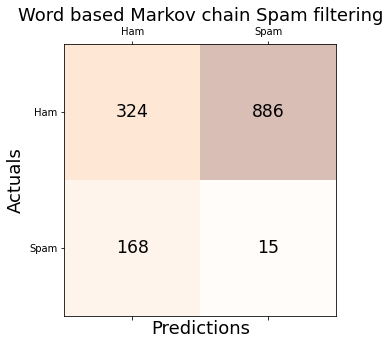

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
conf_matrix_word = np.array([[TP, FN], [FP, TN]])
ax.matshow(conf_matrix_word, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_word.shape[0]):
    for j in range(conf_matrix_word.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_word[i, j], va='center', ha='center', size='xx-large')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham', 'Spam'])
ax.set_yticklabels(['Ham', 'Spam'])

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Word based Markov chain Spam filtering', fontsize=18)
plt.show()

In [14]:
"""
Char based processing.

TP: Expected - Ham, Predicted - Ham
TN: Expected - Spam, Predicted - Spam
FP: Expected - Spam, Predicted - Ham
FN: Expected - Ham, Predicted - Spam
"""
(TP, FP, TN, FN) = process_test_messages(test_set, 'char')

precision = TP/(FP + TP)
recall = TP / (FN + TP)
f1 = 2*precision*recall/ (precision + recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 score: " + str(f1))

Precision: 0.858560794044665
Recall: 0.8578512396694215
F1 score: 0.8582058701942952


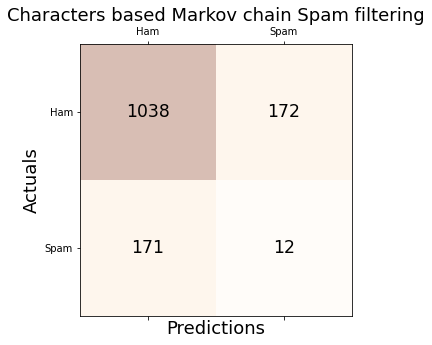

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
conf_matrix_char = np.array([[TP, FN], [FP, TN]])
ax.matshow(conf_matrix_char, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_word.shape[0]):
    for j in range(conf_matrix_word.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_char[i, j], va='center', ha='center', size='xx-large')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham', 'Spam'])
ax.set_yticklabels(['Ham', 'Spam'])

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Characters based Markov chain Spam filtering', fontsize=18)
plt.show()